# Regularizations

In [37]:
import numpy as np 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

In [38]:
from torchvision import datasets, transforms

In [39]:
train = datasets.MNIST(
    '../data', train = True, download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
    ]),
)

test = datasets.MNIST(
    '../data', train = False,
    transform = transforms.Compose([
        transforms.ToTensor(),
    ]),
)

In [40]:
x = train.data.float() / 255.
y = train.targets 

print(x.shape, y.shape)
x = x.view(x.size(0), -1)
print(x.shape)

input_size = x.size(-1)
output_size = int(max(y)) + 1

print('input_size : %d, output_size : %d' % (input_size, output_size))

torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([60000, 784])
input_size : 784, output_size : 10


In [41]:
# Train / Valid ratio
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print('Train %d / Valid %d / Test %d samples' % (train_cnt, valid_cnt, test_cnt))

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim = 0, index = indices)
y = torch.index_select(y, dim = 0, index = indices)

x = list(x.split(cnts, dim = 0))
y = list(y.split(cnts, dim = 0))

x += [(test.data.float() / 255.).view(test_cnt, -1)]
y += [test.targets]

for x_i, y_i in zip(x, y) : 
    print(x_i.size(), y_i.size())

Train 48000 / Valid 12000 / Test 10000 samples
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


## Build Regularized Model & Optimizer

In [42]:
# Block class 는 linear layer, activation function, batch norm을 포함하고 있음
class Block(nn.Module) : 
    def __init__(self, 
                 input_size,
                 output_size, 
                 use_batch_norm = True,
                 dropout_p = .4) : 
        self.input_size = input_size
        self.output_size = output_size
        self.use_batch_norm = use_batch_norm
        self.dropout_p = dropout_p
        
        super().__init__()
        
        def get_regularizer(use_batch_norm, size) : 
            return nn.BatchNorm1d(size) if use_batch_norm else nn.Dropout(dropout_p)
        
        self.block = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.LeakyReLU(),
            get_regularizer(use_batch_norm, output_size),
        )
        
    def forward(self, x) : 
        y = self.block(x)
        
        return y

In [43]:
class Mymodel(nn.Module) : 
    def __init__(self, 
                 input_size,
                 output_size, 
                 use_batch_norm = True,
                 dropout_p = .4) : 
        self.input_size = input_size
        self.output_size = output_size
        self.use_batch_norm = use_batch_norm
        self.dropout_p = dropout_p
        
        super().__init__()
        
        self.layers = nn.Sequential(
            Block(input_size, 500, use_batch_norm, dropout_p),
            Block(500, 400, use_batch_norm, dropout_p),
            Block(400, 300, use_batch_norm, dropout_p),
            Block(300, 200, use_batch_norm, dropout_p),
            Block(200, 100, use_batch_norm, dropout_p),
            nn.Linear(100, output_size),
            nn.LogSoftmax(dim = -1),
        )
        
    def forward(self, x) : 
        y = self.layers(x)
        
        return y

In [44]:
model = Mymodel(input_size,
                output_size,
                use_batch_norm = True)

model

Mymodel(
  (layers): Sequential(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=784, out_features=500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=500, out_features=400, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Block(
      (block): Sequential(
        (0): Linear(in_features=400, out_features=300, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Block(
      (block): Sequential(
        (0): Linear(in_features=300, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(200, e

In [45]:
crit = nn.NLLLoss()

In [46]:
optimizer = optim.Adam(model.parameters())

## Move to GPU if it is available 

In [47]:
device = torch.device('cpu')
if torch.cuda.is_available() : 
    device = torch.device('cuda')
else : 
    print('Not available')

Not available


In [48]:
model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

## Train

In [49]:
n_epochs = 1000
batch_size = 256
print_interval = 10

In [50]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None 

lowest_epoch = np.inf
early_stop = 50

In [55]:
train_history, valid_history = [], []

for i in range(n_epochs) :  # epoch loop
    model.train() # train mode
    
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim = 0, index = indices)
    y_ = torch.index_select(y[0], dim = 0, index = indices)
    
    x_ = x_.split(batch_size, dim = 0)
    y_ = y_.split(batch_size, dim = 0)
    
    train_loss, valid_loss = 0, 0
    y_hat = [] 
    
    # batch loop
    for x_i, y_i in zip(x_, y_) :
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        train_loss += float(loss)
        
    train_loss = train_loss / len(x_)
    
    model.eval() # valid mode # must be included ! 
    with torch.no_grad() : 
        x_ = x[1].split(batch_size, dim = 0)
        y_ = y[1].split(batch_size, dim = 0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_) : 
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze()) 
            
            valid_loss += float(loss)
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
    
    if (i + 1) % print_interval == 0 : 
        print('Epoch %d : train loss = %.4e, valid loss = %.4e, lowest_loss = %.4e' % (
        i + 1, 
        train_loss, 
        valid_loss, 
        lowest_loss
        ))
        
    if valid_loss <= lowest_loss : 
        lowest_loss = valid_loss 
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
        
    else : 
        if early_stop > 0 and lowest_epoch + early_stop < i + 1 : 
            print('There is no improvement during last %d epochs' % early_stop)
            break 
            
print('The best validation loss from epoch %d : %4e' % (lowest_epoch, lowest_loss))
model.load_state_dict(best_model)

Epoch 10 : train loss = 1.2796e-02, valid loss = 8.0142e-02, lowest_loss = 6.8499e-02
Epoch 20 : train loss = 7.0670e-03, valid loss = 8.5131e-02, lowest_loss = 6.8499e-02
Epoch 30 : train loss = 6.2831e-03, valid loss = 8.7876e-02, lowest_loss = 6.8499e-02
Epoch 40 : train loss = 5.9693e-03, valid loss = 9.2461e-02, lowest_loss = 6.8499e-02
Epoch 50 : train loss = 2.8308e-03, valid loss = 7.7230e-02, lowest_loss = 6.8499e-02
There is no improvement during last 50 epochs
The best validation loss from epoch 7 : 6.849916e-02


<All keys matched successfully>

## Loss History

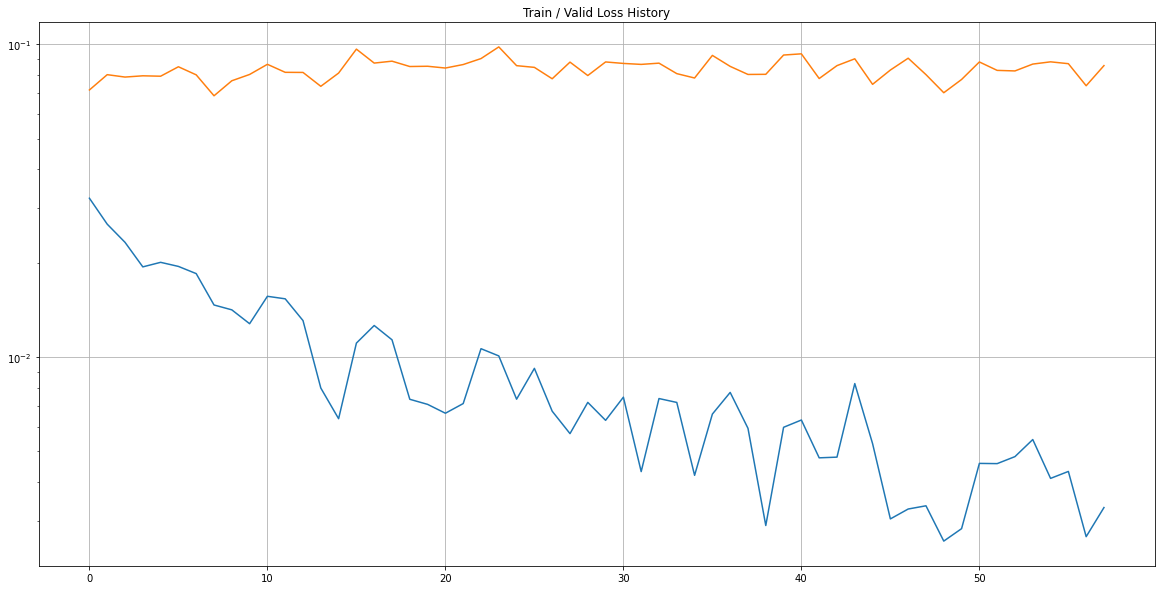

In [56]:
plot_from = 0

plt.figure(figsize = (20, 10))
plt.grid(True)
plt.title('Train / Valid Loss History')
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

## Result 

In [57]:
test_loss = 0
y_hat = [] 

model.eval()

with torch.no_grad() : 
    x_ = x[2].split(batch_size, dim = 0)
    y_ = y[2].split(batch_size, dim = 0)
    
    for x_i, y_i in zip(x_, y_) : 
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())
        
        test_loss += float(loss)
        y_hat += [y_hat_i]
        
test_loss = test_loss / len(y_)
y_hat = torch.cat(y_hat, dim = 0)

print('Test loss : %4e' % test_loss)

Test loss : 7.204068e-02


In [58]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim = -1)).sum()
total_cnt = float(y[-1].size(0))

print('Accuracy : %.4f' % (correct_cnt / total_cnt))

Accuracy : 0.9806


In [59]:
import pandas as pd 
from sklearn.metrics import confusion_matrix

In [63]:
pd.DataFrame(confusion_matrix(y[-1], torch.argmax(y_hat, dim = -1)),
            index = ['true_%d' % i for i in range(10)],
            columns = ['pred_%d' % i for i in range(10)]
            )

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,974,1,1,0,0,1,1,1,1,0
true_1,0,1123,1,1,3,0,4,1,2,0
true_2,2,3,1020,1,0,0,0,3,2,1
true_3,0,0,3,1001,0,3,0,2,1,0
true_4,0,0,5,0,956,0,4,1,0,16
true_5,3,0,0,14,3,860,6,1,0,5
true_6,6,2,3,1,4,4,936,0,2,0
true_7,1,4,6,1,3,0,0,1002,2,9
true_8,4,0,6,10,1,3,1,4,941,4
true_9,1,2,0,3,5,0,0,2,3,993
